# Evaluation Tessa

In this notebook, we calculate the performance of Tessa on our datasets. Please run the script tessa_wraper for each dataset before running this notebook.

In [18]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

os.environ['R_HOME'] = 'C:/Users/felix.drost/Anaconda3/envs/tessa_evaluation/Lib/R' 
import rpy2.robjects as rob

In [2]:
import sys
sys.path.append('../mvTCR/tcr_embedding/evaluation')

from Metrics import get_knn_classification, get_normalized_mutual_information
from Metrics import get_silhouette_scores

C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions for Tessa embedding

In [3]:
def get_tessa_weights(base_dir):
    """
    Load the b-values from the result RData
    :param base_dir: path to the base folder of the experiment
    :return: numpy array [3] giving the b-weights
    """
    rob.r['load'](f'{base_dir}/res/tessa_final.RData')
    b = rob.r['tessa_results'][0]
    b = np.array(b)
    return b


def get_tessa_unweighted_distances(base_dir):
    """
    Extract the Briseis encoding from file
    :param file_dir: path to the base folder of the experiment
    :return: numpy array [num_cells, 30] giving the embedding space by Briseis
    """
    unweighted_dist = pd.read_csv(f'{base_dir}/tessa_tcr_embedding.csv', index_col=0)
    unweighted_dist = unweighted_dist.values
    return unweighted_dist


def get_weighted_distances(unweighted_dist, b):
    """
    Calculates the weigthed distance
    :param unweighted_dist: numpy array [num_cells, 30] giving the TCR embedding
    :param b: numpy array [30] giving the position weights
    :return: numpy array [num_cells, 30] giving the weighted embedding
    """
    weighted_dist = unweighted_dist * b
    return weighted_dist

def calculate_embedding(dataset, split, donor=None, do_atlas=True, do_weighting=True):
    suffix = 'atlas' 
    if not do_atlas:
        suffix = 'query'
    base_dir = f'../results/tessa/{dataset}/'
    if donor is not None:
        base_dir += f'{donor}/'
    base_dir += f'{split}'    
    embedding = get_tessa_unweighted_distances(f'{base_dir}/{suffix}')

    if do_weighting:
        b = get_tessa_weights(f'{base_dir}/atlas')
        embedding = get_weighted_distances(embedding, b)
    return embedding

## Helper Functions

In [58]:
def get_labels(split, donor, return_df=False, col='binding_name'):
    """
    Extract the labels from the TCR file
    :param donor: id of the 10x donor
    :return: list [num_cells], list [num_cells] representing the binding labels for atlas and query set
    """
    if donor != 'Minervina':
        path_labels = f'../mvTCR/data/tessa/10x/{donor}/{split}_'
    else:
        path_labels = f'../mvTCR/data/tessa/{donor}/{split}_'
    df_atlas = pd.read_csv(path_labels+'tcrs_atlas.csv')
    df_query = pd.read_csv(path_labels+'tcrs_query.csv')
    if not return_df:
        return df_atlas[col].tolist(), df_query[col].tolist()
    df_atlas = df_atlas[['contig_id', col]]
    df_query = df_query[['contig_id', col]]
    
    df_atlas = df_atlas.set_index('contig_id')
    df_atlas.index.name = None
    df_query = df_query.set_index('contig_id')
    df_query.index.name = None
    return df_atlas, df_query

In [51]:
def get_tessa_clusters(split, donor):
    path_file = '../results/tessa/'
    if donor in ['covid', 'Borcherding', 'Haniffa', 'Minervina']:
        path_file += f'{donor}/'
    else:
        path_file += f'10x/{donor}/'
    path_file += f'{split}/atlas/res/tessa_final.RData'
    rob.r['load'](path_file)
    clusters = rob.r['tessa_results'][1]

    barcodes = list(clusters[0])
    group_IDs = list(clusters[1])
    cluster_numbers = list(clusters[2])
    df_clusters = pd.DataFrame({'barcode': barcodes, 'group_ID': group_IDs, 'cluster_number': cluster_numbers})
  
    df_clusters['barcode'] = [name.replace('.', '-') for name in df_clusters['barcode']]
    df_clusters = df_clusters.set_index('barcode')
    df_clusters.index.name = None
    df_clusters.columns = ['group', 'cluster']
    return df_clusters

## 10x

In [7]:
dataset = '10x'

model_names = []
splits = []
metrics = []
scores = []
donors = []

for donor in ['donor_1', 'donor_2', 'donor_3', 'donor_4', 'full']:
    for i in tqdm(range(5)):
        split = f'split_{i}'
        print(split)

        # KNN Evaluation
        embedding_atlas = calculate_embedding(dataset, split, donor, do_atlas=True, do_weighting=True)
        embedding_query = calculate_embedding(dataset, split, donor, do_atlas=False, do_weighting=True)

        labels_atlas, labels_query = get_labels(split, donor)

        score = get_knn_classification(embedding_atlas, embedding_query, labels_atlas, labels_query)
        score = score['weighted avg']['f1-score']

        model_names.append('tessa')
        splits.append(i)
        metrics.append(f'Prediction test')
        scores.append(score)
        donors.append(donor)
        
        # Clustering Evaluation
        labels_atlas, _ = get_labels(split, donor, return_df=True)
        labels_predicted = get_tessa_clusters(split, donor)
        df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
        score = get_normalized_mutual_information(df_full['binding_name'], df_full['cluster'])

        model_names.append('tessa')
        splits.append(i)
        metrics.append(f'NMI')
        scores.append(score)
        donors.append(donor)
    
    
results_10x_tessa = {
    'model': model_names,
    'split': splits,
    'metric': metrics,
    'score': scores,
    'donor': donors,
}
results_10x_tessa = pd.DataFrame(results_10x_tessa)
results_10x_tessa.to_csv('../results/performance_tessa_10x.csv')
results_10x_tessa

donor_1
split_0


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

split_1


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


split_2


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

split_3


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

split_4


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

donor_2
split_0


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

split_1


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

split_2


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


split_3


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


split_4


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

donor_3
split_0


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

split_1


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

split_2


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

split_3


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

split_4


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

donor_4
split_0
split_1


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

split_2
split_3


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From ver

split_4
full
split_0


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


split_1


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


split_2


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


split_3


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


split_4


C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


,model,split,metric,score,donor
0,tessa,0,Prediction test,0.680058,donor_1
1,tessa,0,NMI,0.489977,donor_1
2,tessa,1,Prediction test,0.807037,donor_1
3,tessa,1,NMI,0.512067,donor_1
4,tessa,2,Prediction test,0.611818,donor_1
5,tessa,2,NMI,0.535020,donor_1
6,tessa,3,Prediction test,0.749910,donor_1
7,tessa,3,NMI,0.550911,donor_1
8,tessa,4,Prediction test,0.212988,donor_1
9,tessa,4,NMI,0.449310,donor_1


In [8]:
results_10x_tessa.groupby(['donor', 'metric']).mean()

split     score
donor   metric                          
donor_1 NMI                  2  0.507457
        Prediction test      2  0.612362
donor_2 NMI                  2  0.382795
        Prediction test      2  0.639023
donor_3 NMI                  2  0.020899
        Prediction test      2  0.882810
donor_4 NMI                  2  0.483627
        Prediction test      2  0.658715
full    NMI                  2  0.357783
        Prediction test      2  0.383015

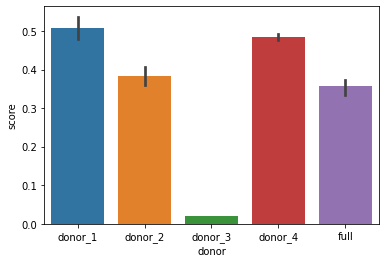

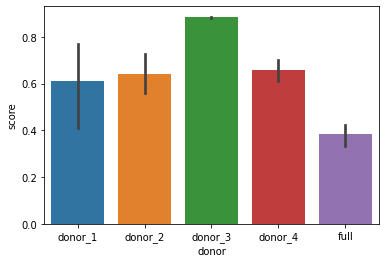

In [14]:
import seaborn as sb
import matplotlib.pyplot as plt
for met in ['NMI', 'Prediction test']:
    res_tmp = results_10x_tessa[results_10x_tessa['metric']==met]
    sb.barplot(data=res_tmp, x='donor', y='score')
    plt.show()

## Minervina dataset

In [60]:
dataset = 'Minervina'

splits = []
metrics = []
scores = []

for i in tqdm(range(5)):
    split = f'split_{i}'

    # KNN Evaluation
    embedding_atlas = calculate_embedding(dataset, split, None, do_atlas=True, do_weighting=True)
    embedding_query = calculate_embedding(dataset, split, None, do_atlas=False, do_weighting=True)

    labels_atlas, labels_query = get_labels(split, dataset, col='epitope')

    score = get_knn_classification(embedding_atlas, embedding_query, labels_atlas, labels_query)
    score = score['weighted avg']['f1-score']

    splits.append(i)
    metrics.append(f'Prediction test')
    scores.append(score)

    # Clustering Evaluation
    labels_atlas, _ = get_labels(split, dataset, return_df=True, col='epitope')
    labels_predicted = get_tessa_clusters(split, dataset)
    df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
    score = get_normalized_mutual_information(df_full['epitope'], df_full['cluster'])

    splits.append(i)
    metrics.append(f'NMI')
    scores.append(score)
    
    
results_min_tessa = {
    'model': ['tessa'] * len(splits),
    'split': splits,
    'metric': metrics,
    'score': scores,
}
results_min_tessa = pd.DataFrame(results_min_tessa)
results_min_tessa.to_csv('../results/performance_tessa_minervina.csv')
results_min_tessa

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
 20%|████████████████▊                                                                   | 1/5 [00:00<00:03,  1.11it/s]C:\Users\felix.drost\Anaconda3\envs\tessa_evaluation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
 40%|█████████████████████████████████▌                                                  | 2/5 [00:01<00:02,  1.10it/s]C

,model,split,metric,score
0,tessa,0,Prediction test,0.483462
1,tessa,0,NMI,0.317480
2,tessa,1,Prediction test,0.490160
3,tessa,1,NMI,0.290917
4,tessa,2,Prediction test,0.445630
5,tessa,2,NMI,0.308612
6,tessa,3,Prediction test,0.450989
7,tessa,3,NMI,0.315509
8,tessa,4,Prediction test,0.460254
9,tessa,4,NMI,0.300247


## Datasets

In [44]:
def get_labels_dataset(split, dataset, return_df=False, col='T_cells'):
    path_labels = f'../mvTCR/data/tessa/{dataset}/{split}_'
    df_atlas = pd.read_csv(path_labels+'tcrs_atlas.csv')
    if not return_df:
        return df_atlas[col].tolist()
    df_atlas = df_atlas[['contig_id', col]]
    
    df_atlas = df_atlas.set_index('contig_id')
    df_atlas.index = [name.replace('.', '-') for name in df_atlas.index]
    
    df_atlas.index.name = None
    return df_atlas

In [16]:
dataset_2_celltype = {
    'Haniffa': 'full_clustering',
    'covid': 'T_cells',
    'Borcherding': 'functional.cluster',
}

In [46]:
ds = ['covid', 'Borcherding', 'Haniffa']

model_names = []
splits = []
metrics = []
scores = []
datasets = []

for dataset in ds:
    for i in tqdm(range(5)):
        split = f'split_{i}'
        celltype_col = dataset_2_celltype[dataset]

        # Celltype
        labels_atlas = get_labels_dataset(split, dataset, return_df=True, col=dataset_2_celltype[dataset])
        labels_predicted = get_tessa_clusters(split, dataset)
        df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
        score = get_normalized_mutual_information(df_full[celltype_col], df_full['cluster'])

        model_names.append('tessa')
        splits.append(i)
        metrics.append(f'NMI_celltype')
        scores.append(score)
        datasets.append(dataset)

        # Reactivity
        labels_atlas = get_labels_dataset(split, dataset, return_df=True, col='cdr3')
        labels_predicted = get_tessa_clusters(split, dataset)
        df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
        score = get_normalized_mutual_information(df_full['cdr3'], df_full['cluster'])

        model_names.append('tessa')
        splits.append(i)
        metrics.append(f'NMI_clonotype')
        scores.append(score)
        datasets.append(dataset)
    
results_tessa_characteristics = {
    'model': model_names,
    'split': splits,
    'metric': metrics,
    'score': scores,
    'dataset': datasets
}
results_tessa_characteristics = pd.DataFrame(results_tessa_characteristics)
results_tessa_characteristics.to_csv('../results/performance_tessa_characteristics.csv')
results_tessa_characteristics

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.97s/it]


,model,split,metric,score,dataset
0,tessa,0,NMI_cell_type,0.154338,covid
1,tessa,0,NMI_clonotype,0.889383,covid
2,tessa,1,NMI_cell_type,0.141279,covid
3,tessa,1,NMI_clonotype,0.886294,covid
4,tessa,2,NMI_cell_type,0.145306,covid
5,tessa,2,NMI_clonotype,0.884723,covid
6,tessa,3,NMI_cell_type,0.149500,covid
7,tessa,3,NMI_clonotype,0.885073,covid
8,tessa,4,NMI_cell_type,0.144616,covid
9,tessa,4,NMI_clonotype,0.883708,covid


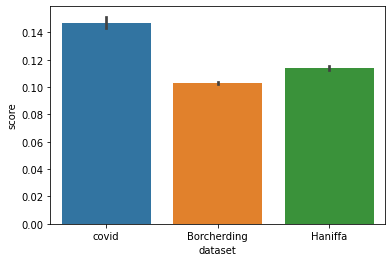

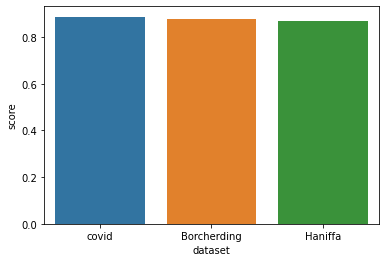

In [48]:
import seaborn as sb
import matplotlib.pyplot as plt
for met in ['NMI_cell_type', 'NMI_clonotype']:
    res_tmp = results_tessa_characteristics[results_tessa_characteristics['metric']==met]
    sb.barplot(data=res_tmp, x='dataset', y='score')
    plt.show()

## Write to Supplementary Material

In [ ]:
path_out = '../results/supplement/S1_benchmarking.xlsx'

with pd.ExcelWriter(path_out, mode='a') as writer:  
    results_10x_tessa.to_excel(writer, sheet_name='tessa_10x')
    results_tessa_characteristics.to_excel(writer, sheet_name='tessa_characteristics')